# Downstream analysis on spatial multi-omics data of human gastric cancer

In this tutorial, we will perform downstream analysis of spatial multi-omics data from the human gastric cancer, including identification of MCC flow, group-level MCC, MCC pattern, MCC remodelling in receiver cells.

In [ ]:
# Importing packages
import os
import metachat as mc
import numpy as np
import scanpy as sc

import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [5]:
# Setting your work dictionary
os.chdir("/home/project/metachat_packages/")

## Import MetaChat results

In [7]:
adata = sc.read('datasets/human_gastric_cancer/metachat_result.h5ad')

## Compute group-level MCC of all pairs and all pathways

To summarize MCC patterns between any two group types, we need to compute group-level MCCs across all metabolite–sensor pairs and all pathways.

In [8]:
# extract all_ms_pairs
df_metasen_filtered = adata.uns['df_metasen_filtered']
all_ms_pairs = (df_metasen_filtered['HMDB.ID'] + '-' + df_metasen_filtered['Sensor.Gene']).tolist()

In [9]:
# extract all_metapathways
Metapathway_data = df_metasen_filtered["Metabolite.Pathway"].copy()
Metapathway_list = []
for item in Metapathway_data:
    split_items = item.split('; ')
    Metapathway_list.extend(split_items)
all_metapathways = np.unique(Metapathway_list).tolist()
all_metapathways = [x for x in all_metapathways if x != 'nan']

The original output of MetaChat provides MCC signals for each individual metabolite–sensor pair.
Here, we use `mc.tl.summary_communication` to summarize the overall MCC activity associated with specific metabolic pathway, aggregating their communication strengths across all corresponding sensors.

In [10]:
mc.tl.summary_communication(adata = adata,
                            database_name = 'MetaChatDB',
                            sum_metapathways = all_metapathways)

Meanwhile, all metabolite–sensor pairs and pathways can be processed together in parallel using the `use_parallel=True` option. Here, we use the non-spatial version of the statistical test for all metabolite–sensor pairs, since only the group-level MCC scores (rather than p-values) are needed in downstream analyses, allowing faster computation while retaining the same information content.

In [11]:
mc.tl.communication_group(adata = adata,
                          database_name = 'MetaChatDB',
                          group_name = "tissue_type",
                          sum_ms_pairs = all_ms_pairs,
                          n_permutations = 100,
                          use_parallel = True,
                          n_jobs = 100)

  Computing group-level MCC: 100%|██████████| 610/610 [00:19<00:00, 31.70it/s]


In [12]:
mc.tl.communication_group_spatial(adata = adata,
                                  database_name = 'MetaChatDB',
                                  group_name = "tissue_type",
                                  sum_metapathways = all_metapathways,
                                  n_permutations = 100,
                                  use_parallel = True,
                                  n_jobs = 100)

  Computing group-level MCC: 100%|██████████| 8100/8100 [11:31<00:00, 11.71it/s]


We can first visualize the group-level MCC across all signaling pairs.

Text(0.5, 1.0, 'Group-level MCC')

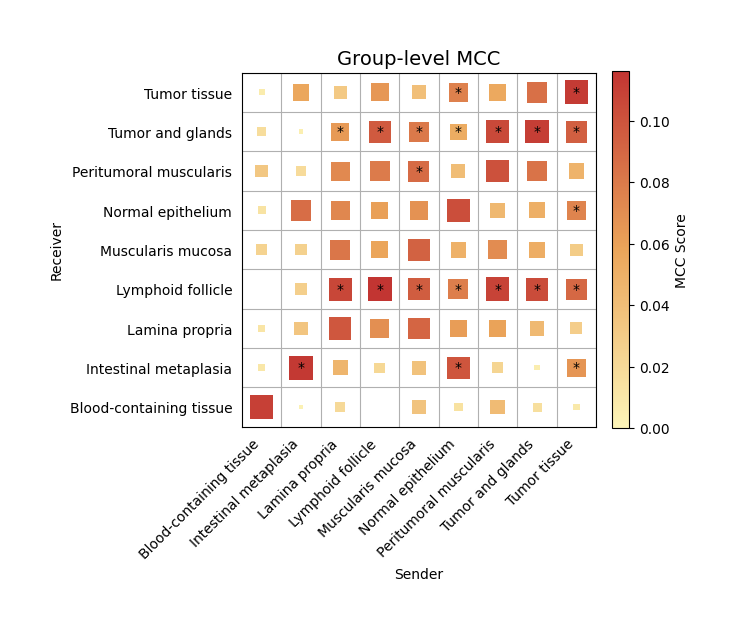

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))
mc.pl.plot_group_communication_heatmap(adata = adata,
                                       database_name = 'MetaChatDB',
                                       group_name = "tissue_type",
                                       cmap = 'red',
                                       permutation_spatial = True,
                                       ax = ax)
ax.set_title('Group-level MCC', fontsize=14)

We can observe significant interactions from the tumor tissue toward the surrounding gland regions.

## Summary MCC pattern from tumor tissue to glands

In this step, we summarize the MCC pattern specifically from the tumor tissue to the surrounding glands.
By specifying the sender and receiver groups, the `mc.tl.summary_pathway` function integrates all metabolite–sensor pairs within each pathway and evaluates their overall contributions.

In [14]:
sender_group = "Tumor tissue"
receiver_group = "Tumor and glands"
metapathway_rank, senspathway_rank, ms_result, metapathway_pair_contributions = mc.tl.summary_pathway(
    adata = adata,
    database_name = 'MetaChatDB',
    group_name = "tissue_type",
    sender_group = sender_group,
    receiver_group = receiver_group,
    permutation_spatial = True)

The function mc.tl.summary_pathway() outputs four complementary tables that summarize group-level MCC at multiple biological levels:  

•	`metapathway_rank` lists metabolite pathways ranked by their overall communication score, indicating which metabolic routes most contribute to the MCC between the selected sender and receiver groups.  

•	`senspathway_rank` ranks sensor-associated signaling pathways by their Rankscore, reflecting how strongly each receptor or signaling cascade is involved in receiving or responding to metabolite-mediated communication.  

•	`ms_result` is a matrix showing pairwise communication scores between each metabolite pathway and sensor pathway, capturing how specific metabolic routes couple to particular receptor signaling modules.  

•	`metapathway_pair_contributions` provides detailed contributions from individual metabolite–sensor pairs within each metabolite pathway, allowing fine-grained inspection of which molecular interactions drive the observed pathway-level MCC.  


In [15]:
sender_group = "Tumor tissue"
receiver_group = "Tumor and glands"
mc.pl.plot_summary_pathway(ms_result = ms_result,
                           metapathway_rank = metapathway_rank,
                           senspathway_rank = senspathway_rank,
                           plot_metapathway_index = [2,3,5,7,8],
                           plot_senspathway_index = [0,1,3,5,16],
                           figsize = (8,4))

### Glycolysis / Gluconeogenesis pathway

Visualize the spatial distribution of MCC flow and signaling strength for the `Glycolysis / Gluconeogenesis` pathway.

In [16]:
metapathway_name = "Glycolysis_Gluconeogenesis"
mc.tl.communication_flow(adata = adata,
                         database_name = 'MetaChatDB',
                         sum_metapathways = [metapathway_name],
                         k = 10)

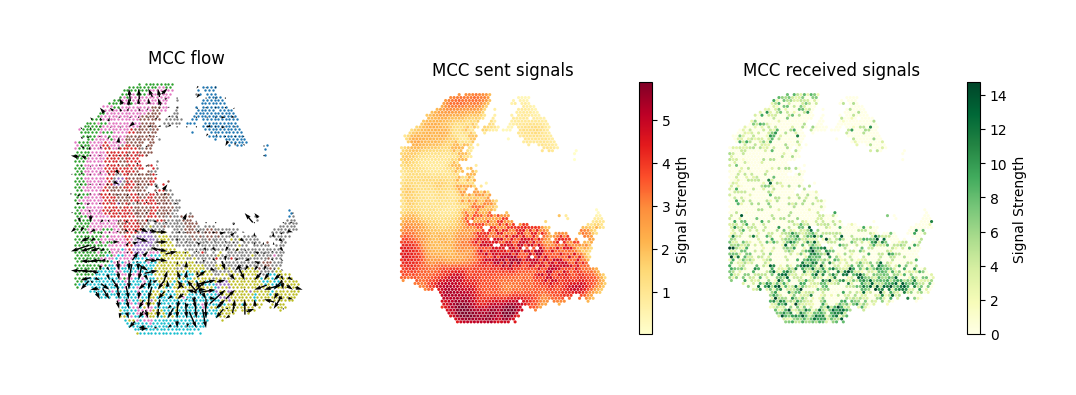

In [17]:
fig, ax = plt.subplots(1, 3, figsize=(12,4))
pl1 = mc.pl.plot_communication_flow(adata = adata, 
                                    database_name = 'MetaChatDB',
                                    metapathway_name = metapathway_name,
                                    plot_method = 'grid',
                                    background = 'group',
                                    group_name = 'tissue_type',
                                    summary = 'receiver',
                                    ndsize = 3,
                                    largest_arrow = 0.05,
                                    normalize_v_quantile = 0.995,
                                    grid_density = 0.5,
                                    title = 'MCC flow',   
                                    ax = ax[0])
ax[0].set_box_aspect(1)

pl2 = mc.pl.plot_communication_flow(adata = adata, 
                                    database_name = 'MetaChatDB',
                                    metapathway_name = metapathway_name,
                                    plot_method = None,
                                    background = 'summary',
                                    group_name = 'tissue_type',
                                    summary = 'sender',
                                    cmap = 'YlOrRd',
                                    ndsize = 5,
                                    largest_arrow = 0.05,
                                    normalize_v_quantile = 0.995,
                                    grid_density = 0.4,
                                    title = 'MCC sent signals',   
                                    ax = ax[1])
ax[1].set_box_aspect(1)

pl3 = mc.pl.plot_communication_flow(adata = adata, 
                                    database_name = 'MetaChatDB',
                                    metapathway_name = metapathway_name,
                                    plot_method = None,
                                    background = 'summary',
                                    group_name = 'tissue_type',
                                    summary = 'receiver',
                                    cmap = 'YlGn',
                                    ndsize = 5,
                                    largest_arrow = 0.05,
                                    normalize_v_quantile = 0.995,
                                    grid_density = 0.4,
                                    title = 'MCC received signals',   
                                    ax = ax[2])
ax[2].set_box_aspect(1)

We can use bubble plot to visualize the metabolite–sensor (M–S) pair contributions within the Glycolysis and Gluconeogenesis pathway, focusing on communication from tumor tissue to glands. The bubble size reflects the relative contribution score of each pair, categorized into quantiles of the overall distribution, illustrating which metabolites and sensors are most active in mediating pathway-specific metabolic communication.

<Axes: title={'center': 'M-S pair contributions for Glycolysis_Gluconeogenesis (Tumor tissue to glands)'}, xlabel='Sensors', ylabel='Metabolites'>

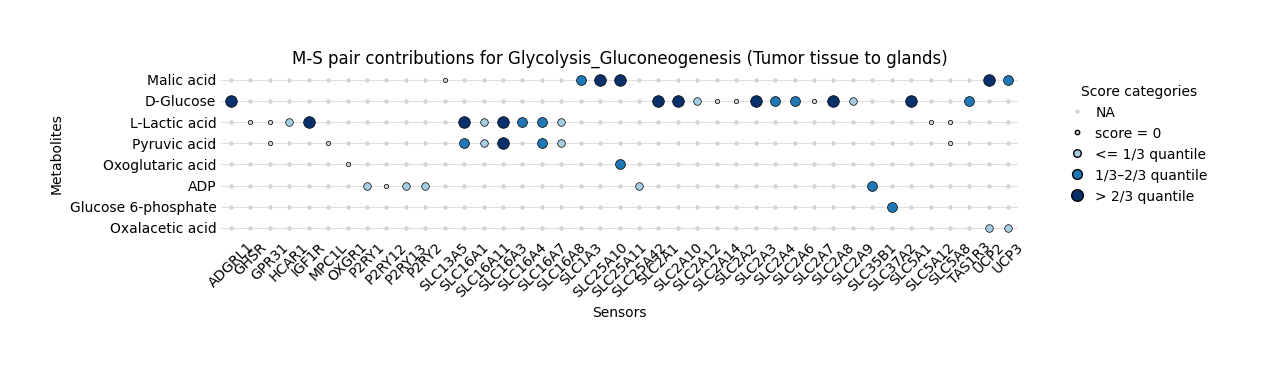

In [18]:
pathway_name = "Glycolysis_Gluconeogenesis"
mc.pl.plot_metapathway_pair_contribution_bubbleplot(
    pathway_pair_contributions = metapathway_pair_contributions,
    pathway_name = pathway_name,
    cmap = "blue",
    smallest_size = 10,
    figsize=(12, 3),
    plot_title = f"M-S pair contributions for {pathway_name} (Tumor tissue to glands)"
)

### Aspartate Metabolism pathway

Visualize the spatial distribution of MCC flow and signaling strength for the `Aspartate Metabolism` pathway.

In [19]:
metapathway_name = "Aspartate Metabolism"
mc.tl.communication_flow(adata = adata,
                         database_name = 'MetaChatDB',
                         sum_metapathways = [metapathway_name],
                         k = 10)

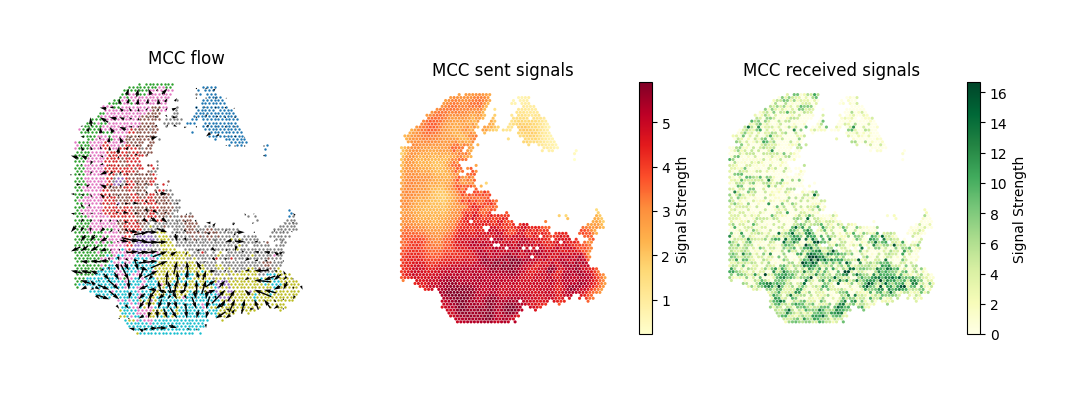

In [20]:
fig, ax = plt.subplots(1, 3, figsize=(12,4))
pl1 = mc.pl.plot_communication_flow(adata = adata, 
                                    database_name = 'MetaChatDB',
                                    metapathway_name = metapathway_name,
                                    plot_method = 'grid',
                                    background = 'group',
                                    group_name = 'tissue_type',
                                    summary = 'receiver',
                                    ndsize = 3,
                                    largest_arrow = 0.05,
                                    normalize_v_quantile = 0.995,
                                    grid_density = 0.5,
                                    title = 'MCC flow',   
                                    ax = ax[0])
ax[0].set_box_aspect(1)

pl2 = mc.pl.plot_communication_flow(adata = adata, 
                                    database_name = 'MetaChatDB',
                                    metapathway_name = metapathway_name,
                                    plot_method = None,
                                    background = 'summary',
                                    group_name = 'tissue_type',
                                    summary = 'sender',
                                    cmap = 'YlOrRd',
                                    ndsize = 5,
                                    largest_arrow = 0.05,
                                    normalize_v_quantile = 0.995,
                                    grid_density = 0.4,
                                    title = 'MCC sent signals',   
                                    ax = ax[1])
ax[1].set_box_aspect(1)

pl3 = mc.pl.plot_communication_flow(adata = adata, 
                                    database_name = 'MetaChatDB',
                                    metapathway_name = metapathway_name,
                                    plot_method = None,
                                    background = 'summary',
                                    group_name = 'tissue_type',
                                    summary = 'receiver',
                                    cmap = 'YlGn',
                                    ndsize = 5,
                                    largest_arrow = 0.05,
                                    normalize_v_quantile = 0.995,
                                    grid_density = 0.4,
                                    title = 'MCC received signals',   
                                    ax = ax[2])
ax[2].set_box_aspect(1)

<Axes: title={'center': 'M-S pair contributions for Aspartate Metabolism (Tumor tissue to glands)'}, xlabel='Sensors', ylabel='Metabolites'>

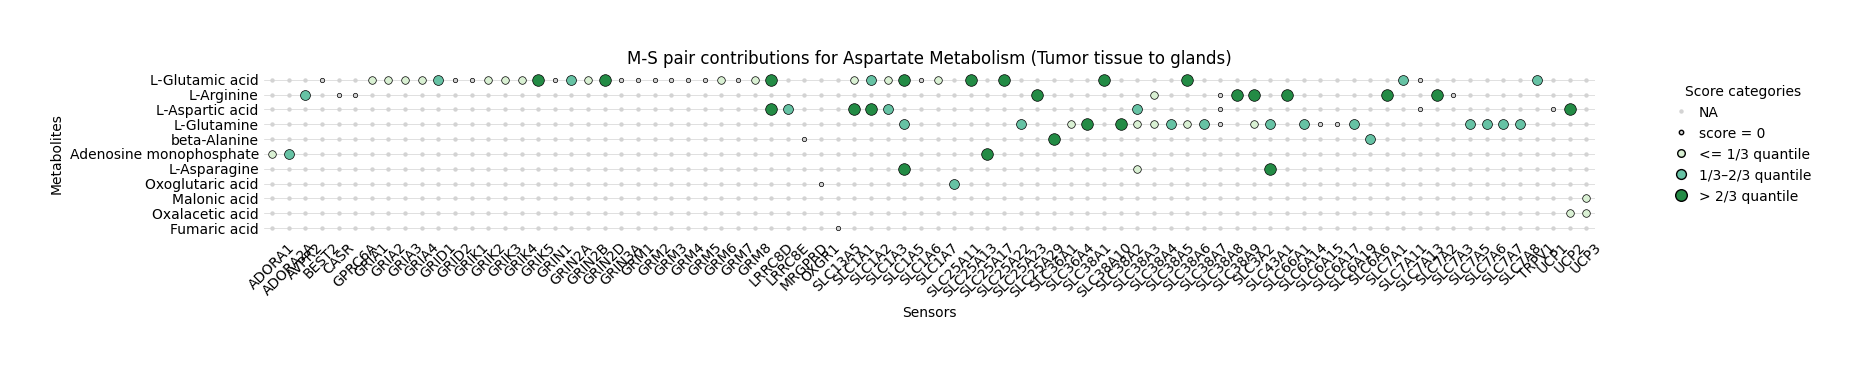

In [23]:
pathway_name = "Aspartate Metabolism"
mc.pl.plot_metapathway_pair_contribution_bubbleplot(
    pathway_pair_contributions = metapathway_pair_contributions,
    pathway_name = pathway_name,
    cmap = "green",
    smallest_size = 10,
    figsize=(18, 3),
    plot_title = f"M-S pair contributions for {pathway_name} (Tumor tissue to glands)"
)

## MCC remodelling in receiver cells

In the next step, we aim to identify response genes in receiver cells. To do this, we provide the corresponding raw RNA data (`adata_raw`) as reference, which allows MetaChat to estimate transcriptional changes associated with signaling activity.

In [24]:
adata_raw = sc.read('datasets/human_gastric_cancer/adata_RNA_raw.h5ad')

### Glycolysis / Gluconeogenesis pathway

In [25]:
metapathway_name = 'Glycolysis_Gluconeogenesis'
df_deg, df_yhat = mc.tl.communication_responseGenes(adata = adata,
                                                    adata_raw = adata_raw,
                                                    database_name = 'MetaChatDB',
                                                    metapathway_name = metapathway_name,
                                                    group_name = 'tissue_type',
                                                    summary = 'receiver')

/opt/conda/envs/metachat_test_20251015/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

100%|██████████| 100/100 [00:09<00:00, 10.86/s]


  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~08m 26s       |+                                                 | 2 % ~08m 18s       |++                                                | 3 % ~07m 49s       |++                                                | 4 % ~07m 40s       |+++                                               | 5 % ~07m 27s       |+++                                               | 6 % ~07m 18s       |++++                                              | 7 % ~07m 14s       |++++                                              | 8 % ~07m 09s       |+++++                                             | 9 % ~07m 04s       |+++++                                             | 10% ~07m 07s       |++++++                                            | 11% ~07m 01s       |++++++                                            | 12% ~07m 52s       |+++++++                                           | 13% ~07m 

We can optionally remove ribosomal and mitochondrial genes from the analysis to reduce background noise and focus on biologically relevant communication response genes.

In [26]:
import re
pattern = re.compile(r'^(RPL|RPS|MT\-|NDU|CO|ATP5)')
mask = ~df_deg.index.to_series().str.match(pattern)
df_deg = df_deg[mask].copy()

df_deg_clus, df_yhat_clus = mc.tl.communication_responseGenes_cluster(df_deg.iloc[:,:3], df_yhat, deg_clustering_res=0.3)

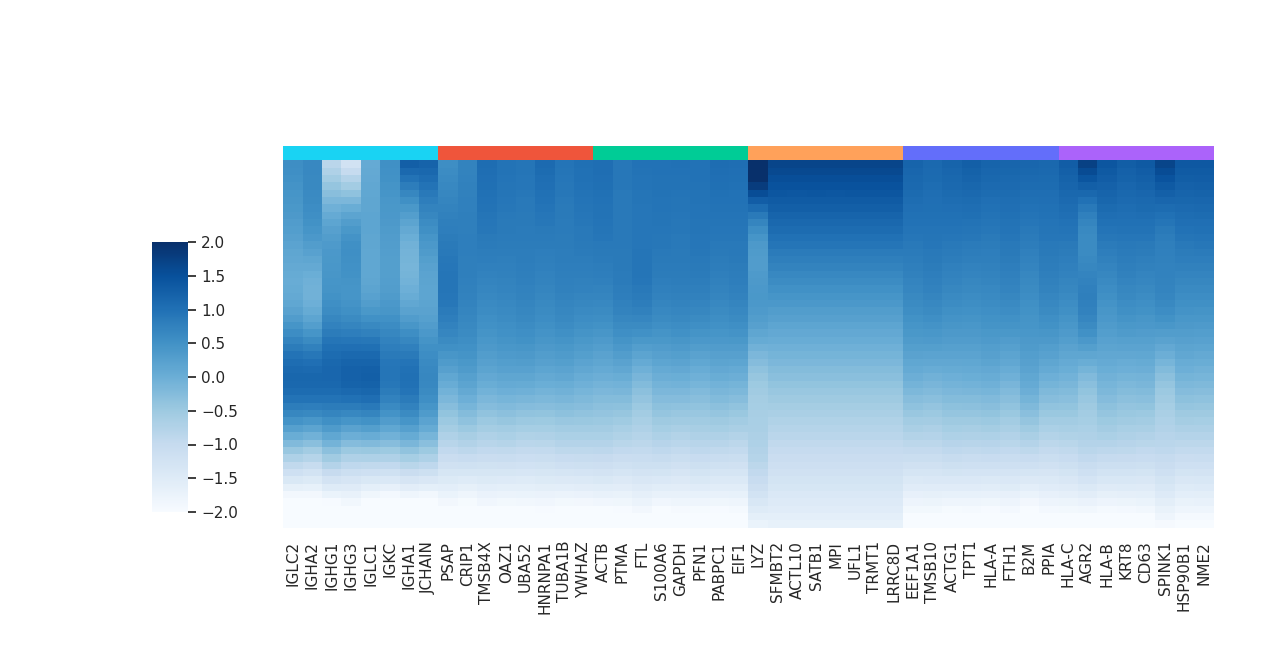

In [27]:
mc.pl.plot_communication_responseGenes(df_deg = df_deg_clus,
                                       df_yhat = df_yhat_clus,
                                       top_ngene_per_cluster = 8,
                                       colormap = 'Blues',
                                       color_range = (-2,2),
                                       font_scale = 1,
                                       figsize = (12,6))

In [28]:
kegg_result = mc.tl.communication_responseGenes_keggEnrich(
    gene_list = df_deg[df_deg['pvalue'] < 0.05].index.tolist(),
    gene_sets = "KEGG_2021_Human",
    organism = "Human"
)

We can visualize top 30 KEGG pathway in these response genes.

<Axes: xlabel='-log10(p-value)', ylabel='KEGG pathway'>

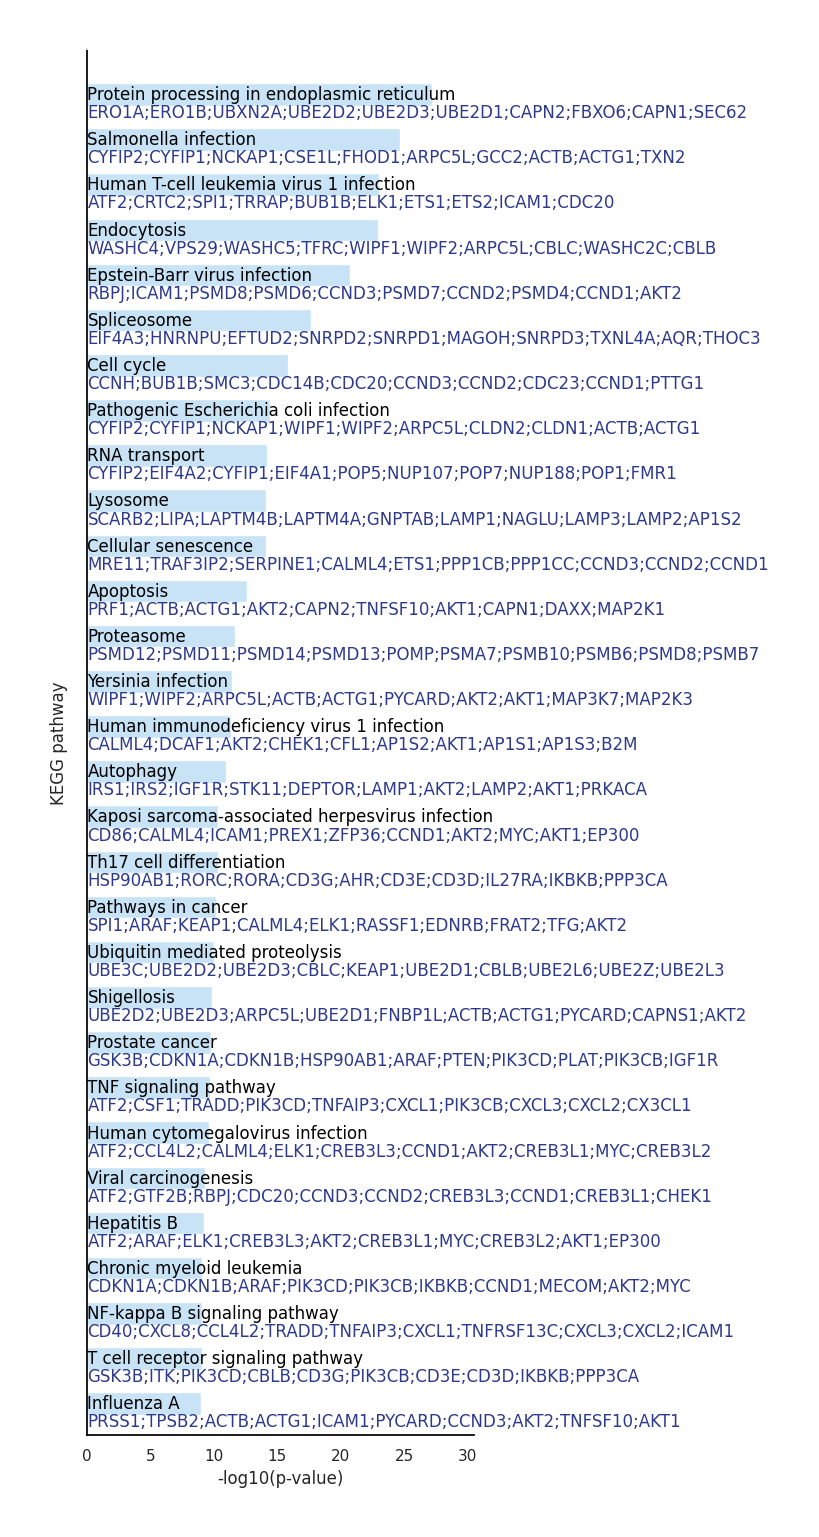

In [31]:
mc.pl.plot_communication_responseGenes_keggEnrich(df_result = kegg_result,
                                                  show_term_order = range(30),
                                                  cmap = 'blue',
                                                  maxshow_gene = 10,
                                                  organism = "Human",
                                                  figsize = (5,18))

### Aspartate Metabolism

In [32]:
metapathway_name = 'Aspartate Metabolism'
df_deg, df_yhat = mc.tl.communication_responseGenes(adata = adata,
                                                    adata_raw = adata_raw,
                                                    database_name = 'MetaChatDB',
                                                    metapathway_name = metapathway_name,
                                                    group_name = 'tissue_type',
                                                    summary = 'receiver')

100%|██████████| 100/100 [00:09<00:00, 10.52/s]


  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~06m 39s       |+                                                 | 2 % ~06m 47s       |++                                                | 3 % ~06m 40s       |++                                                | 4 % ~06m 32s       |+++                                               | 5 % ~06m 22s       |+++                                               | 6 % ~06m 16s       |++++                                              | 7 % ~06m 16s       |++++                                              | 8 % ~06m 15s       |+++++                                             | 9 % ~06m 10s       |+++++                                             | 10% ~06m 09s       |++++++                                            | 11% ~06m 09s       |++++++                                            | 12% ~06m 24s       |+++++++                                           | 13% ~06m 

In [41]:
import re
pattern = re.compile(r'^(RPL|RPS|MT\-|NDU|CO|ATP5)')
mask = ~df_deg.index.to_series().str.match(pattern)
df_deg = df_deg[mask].copy()

df_deg_clus, df_yhat_clus = mc.tl.communication_responseGenes_cluster(df_deg.iloc[:,:3], df_yhat, deg_clustering_res=0.3)

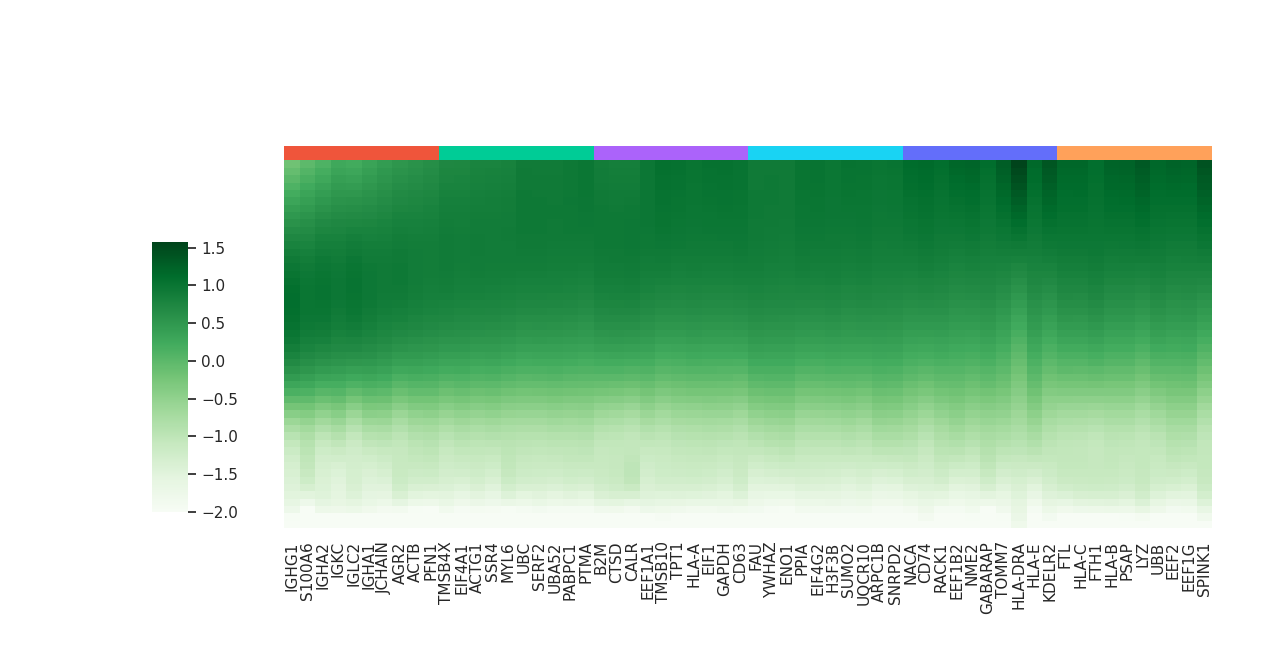

In [42]:
mc.pl.plot_communication_responseGenes(df_deg = df_deg_clus,
                                       df_yhat = df_yhat_clus,
                                       top_ngene_per_cluster = 10,
                                       colormap = 'Greens',
                                       color_range = (-2,2),
                                       font_scale = 1,
                                       figsize = (12,6))

In [43]:
kegg_result = mc.tl.communication_responseGenes_keggEnrich(
    gene_list = df_deg[df_deg['pvalue'] < 0.05].index.tolist(),
    gene_sets = "KEGG_2021_Human",
    organism = "Human"
)

<Axes: xlabel='-log10(p-value)', ylabel='KEGG pathway'>

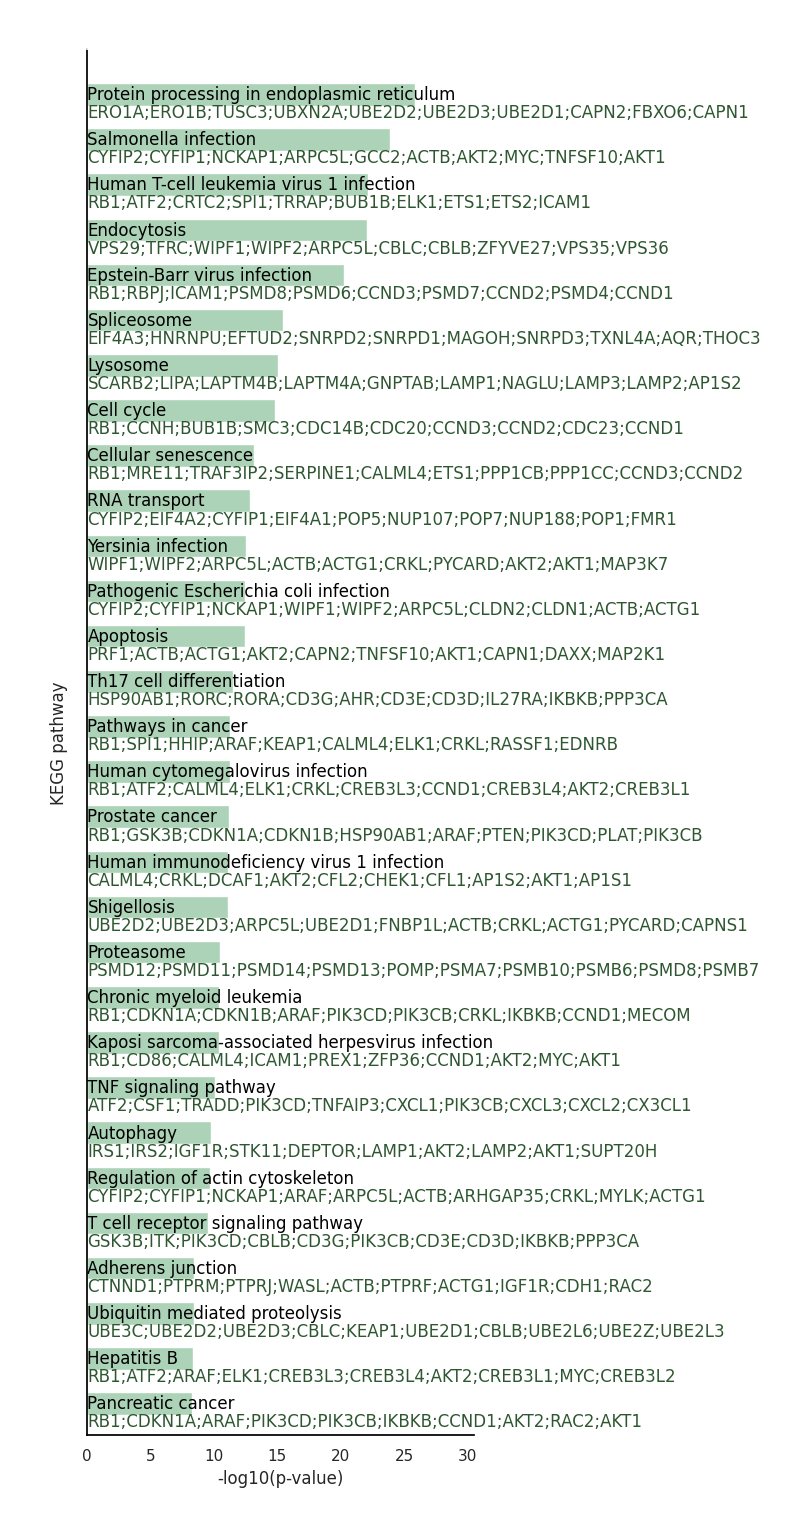

In [44]:
mc.pl.plot_communication_responseGenes_keggEnrich(df_result = kegg_result,
                                                  show_term_order = range(30),
                                                  cmap = 'green',
                                                  maxshow_gene = 10,
                                                  organism = "Human",
                                                  figsize = (5,18))